In [2]:
# Importacao das bibliotecas
import os
from dotenv import load_dotenv

import pandas as pd
import psycopg2 as pg
from sqlalchemy import create_engine
import panel as pn

load_dotenv()

DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '5432')
DB_NAME = os.getenv('DB_NAME', 'assistencia_saude')
DB_USER = os.getenv('DB_USER', 'postgres')
DB_PASS = os.getenv('DB_PASS', '2301')

CNX_STRING = f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

def conectar():
    """Cria conexao com psycopg2"""
    return pg.connect(host=DB_HOST, port=DB_PORT, dbname=DB_NAME, user=DB_USER, password=DB_PASS)

def get_engine():
    """Retorna engine do SQLAlchemy"""
    return create_engine(CNX_STRING)

print('Conexao configurada!')

Conexao configurada!


---

## Inclusao de Dados

**Responsavel:** Jesse

In [ ]:

# TODO: Implementar funcoes de inclusao aqui
# - Incluir Pessoa
# - Incluir Profissional
# - Incluir Consulta
# etc.

pass

---

## Edicao de Dados

**Responsavel:** Juan Pablo

In [ ]:

# TODO: Implementar funcoes de edicao aqui
# - Editar Pessoa
# - Editar Profissional
# - Editar Consulta
# etc.

pass

---

## Remocao de Dados

**Responsavel:** Nayrana

In [ ]:

def remover_consulta(id_consulta):
    with conectar() as conn:
        with conn.cursor() as cur:
            cur.execute("DELETE FROM Consulta WHERE id = %s", (id_consulta,))
            conn.commit()

---

## Consultas com Filtragem

**Responsavel:** Emilly

In [21]:

def buscar_consultas(nome_pessoa=None, nome_profissional=None, tipo_consulta=None, data_inicio=None, data_fim=None):
    """
    Busca consultas com filtros opcionais.
    
    Parametros:
        nome_pessoa: filtrar por nome do paciente
        nome_profissional: filtrar por nome do profissional
        tipo_consulta: filtrar por tipo de consulta
        data_inicio: data inicial do periodo
        data_fim: data final do periodo
    """
    conn = conectar()
    
    query = """
        SELECT 
            c.id,
            p.nome AS paciente,
            pr.nome AS profissional,
            pr.especialidade,
            c.data_consulta,
            c.hora_consulta,
            c.tipo_consulta
        FROM Consulta c
        JOIN Pessoa p ON c.pessoa_id = p.id
        JOIN Profissional pr ON c.profissional_id = pr.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if nome_profissional:
        query += " AND pr.nome ILIKE %s"
        params.append(f'%{nome_profissional}%')
    
    if tipo_consulta:
        query += " AND c.tipo_consulta ILIKE %s"
        params.append(f'%{tipo_consulta}%')
    
    if data_inicio:
        query += " AND c.data_consulta >= %s"
        params.append(data_inicio)
    
    if data_fim:
        query += " AND c.data_consulta <= %s"
        params.append(data_fim)
    
    query += " ORDER BY c.data_consulta DESC, c.hora_consulta DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_pessoas(nome=None, cpf=None, sexo=None, gestante=None):
    """
    Busca pessoas com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            p.id,
            p.nome,
            p.cpf,
            p.data_nascimento,
            p.sexo,
            p.gestante,
            p.deficiencia,
            p.telefone,
            f.codigo_familiar,
            f.responsavel AS responsavel_familia
        FROM Pessoa p
        JOIN Familia f ON p.familia_id = f.id
        WHERE 1=1
    """
    
    params = []
    
    if nome:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome}%')
    
    if cpf:
        query += " AND p.cpf ILIKE %s"
        params.append(f'%{cpf}%')
    
    if sexo:
        query += " AND p.sexo = %s"
        params.append(sexo)
    
    if gestante is not None:
        query += " AND p.gestante = %s"
        params.append(gestante)
    
    query += " ORDER BY p.nome"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_profissionais(nome=None, especialidade=None, agencia=None):
    """
    Busca profissionais com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            pr.id,
            pr.nome,
            pr.cpf,
            pr.telefone,
            pr.email,
            pr.especialidade,
            a.nome AS agencia
        FROM Profissional pr
        JOIN Agencia a ON pr.agencia_id = a.id
        WHERE 1=1
    """
    
    params = []
    
    if nome:
        query += " AND pr.nome ILIKE %s"
        params.append(f'%{nome}%')
    
    if especialidade:
        query += " AND pr.especialidade ILIKE %s"
        params.append(f'%{especialidade}%')
    
    if agencia:
        query += " AND a.nome ILIKE %s"
        params.append(f'%{agencia}%')
    
    query += " ORDER BY pr.nome"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_atendimentos(nome_pessoa=None, tipo_atendimento=None, data_inicio=None, data_fim=None):
    """
    Busca atendimentos com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            a.id,
            p.nome AS paciente,
            pr.nome AS profissional,
            us.nome AS unidade_saude,
            a.data_atendimento,
            a.tipo_atendimento,
            a.descricao
        FROM Atendimento a
        JOIN Pessoa p ON a.pessoa_id = p.id
        JOIN Profissional pr ON a.profissional_id = pr.id
        LEFT JOIN UnidadeSaude us ON a.unidade_saude_id = us.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if tipo_atendimento:
        query += " AND a.tipo_atendimento ILIKE %s"
        params.append(f'%{tipo_atendimento}%')
    
    if data_inicio:
        query += " AND a.data_atendimento >= %s"
        params.append(data_inicio)
    
    if data_fim:
        query += " AND a.data_atendimento <= %s"
        params.append(data_fim)
    
    query += " ORDER BY a.data_atendimento DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_prescricoes(nome_pessoa=None, nome_medicamento=None):
    """
    Busca prescricoes com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            pr.id,
            p.nome AS paciente,
            prof.nome AS profissional,
            m.nome AS medicamento,
            m.principio_ativo,
            pr.data_prescricao,
            pr.dosagem,
            pr.frequencia,
            pr.instrucoes
        FROM Prescricao pr
        JOIN Pessoa p ON pr.pessoa_id = p.id
        JOIN Profissional prof ON pr.profissional_id = prof.id
        JOIN Medicamento m ON pr.medicamento_id = m.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if nome_medicamento:
        query += " AND m.nome ILIKE %s"
        params.append(f'%{nome_medicamento}%')
    
    query += " ORDER BY pr.data_prescricao DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


print('Funcoes de consulta definidas!')

Funcoes de consulta definidas!


### Exemplos de Uso

In [27]:
# Listar todas as consultas
buscar_consultas()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,16,Ana Silva,Dra. Maria Costa,Ginecologista,2025-02-10,10:00:00,Pre-natal
1,15,Joao da Silva,Dr. Pedro Oliveira,Cardiologista,2025-02-01,08:30:00,Cardiologia
2,14,Julia Santos,Dra. Maria Costa,Ginecologista,2025-01-15,16:00:00,Pre-natal
3,13,Carlos Santos,Dr. Pedro Oliveira,Cardiologista,2025-01-14,15:30:00,Cardiologia
4,12,Pedro Oliveira,Dra. Ana Santos,Pediatra,2025-01-13,14:00:00,Pediatrica
5,11,Maria Oliveira,Dr. Carlos Silva,Clinico Geral,2025-01-12,10:00:00,Retorno
6,10,Ana Silva,Dra. Maria Costa,Ginecologista,2025-01-11,09:30:00,Pre-natal
7,9,Joao da Silva,Dr. Carlos Silva,Clinico Geral,2025-01-10,08:00:00,Rotina


In [28]:
# Filtrar consultas por nome do paciente
buscar_consultas(nome_pessoa='Maria')

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,11,Maria Oliveira,Dr. Carlos Silva,Clinico Geral,2025-01-12,10:00:00,Retorno


In [29]:
# Filtrar consultas por periodo
buscar_consultas(data_inicio='2025-01-01', data_fim='2025-12-31')

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,16,Ana Silva,Dra. Maria Costa,Ginecologista,2025-02-10,10:00:00,Pre-natal
1,15,Joao da Silva,Dr. Pedro Oliveira,Cardiologista,2025-02-01,08:30:00,Cardiologia
2,14,Julia Santos,Dra. Maria Costa,Ginecologista,2025-01-15,16:00:00,Pre-natal
3,13,Carlos Santos,Dr. Pedro Oliveira,Cardiologista,2025-01-14,15:30:00,Cardiologia
4,12,Pedro Oliveira,Dra. Ana Santos,Pediatra,2025-01-13,14:00:00,Pediatrica
5,11,Maria Oliveira,Dr. Carlos Silva,Clinico Geral,2025-01-12,10:00:00,Retorno
6,10,Ana Silva,Dra. Maria Costa,Ginecologista,2025-01-11,09:30:00,Pre-natal
7,9,Joao da Silva,Dr. Carlos Silva,Clinico Geral,2025-01-10,08:00:00,Rotina


In [30]:
# Listar todas as pessoas
buscar_pessoas()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:102: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,nome,cpf,data_nascimento,sexo,gestante,deficiencia,telefone,codigo_familiar,responsavel_familia
0,8,Ana Silva,123.456.789-02,1985-03-20,F,True,None,11-98888-1112,FAM001,Joao da Silva
1,11,Carlos Santos,345.678.901-01,1990-01-25,M,False,Visual,11-98888-3333,FAM003,Carlos Santos
2,7,Joao da Silva,123.456.789-01,1980-05-15,M,False,None,11-98888-1111,FAM001,Joao da Silva
3,12,Julia Santos,345.678.901-02,1992-07-30,F,True,None,11-98888-3334,FAM003,Carlos Santos
4,9,Maria Oliveira,234.567.890-01,1975-08-10,F,False,None,11-98888-2222,FAM002,Maria Oliveira
5,10,Pedro Oliveira,234.567.890-02,2010-12-01,M,False,None,11-98888-2223,FAM002,Maria Oliveira


In [31]:
# Filtrar pessoas gestantes
buscar_pessoas(gestante=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:102: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,nome,cpf,data_nascimento,sexo,gestante,deficiencia,telefone,codigo_familiar,responsavel_familia
0,8,Ana Silva,123.456.789-02,1985-03-20,F,True,None,11-98888-1112,FAM001,Joao da Silva
1,12,Julia Santos,345.678.901-02,1992-07-30,F,True,None,11-98888-3334,FAM003,Carlos Santos


In [32]:
# Listar profissionais por especialidade
buscar_profissionais(especialidade='Clinico')

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:144: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,nome,cpf,telefone,email,especialidade,agencia
0,13,Dr. Carlos Silva,111.111.111-11,11-99999-1111,carlos@email.com,Clinico Geral,UBS Centro


In [33]:
# Listar atendimentos
buscar_atendimentos()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:192: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,unidade_saude,data_atendimento,tipo_atendimento,descricao
0,10,Carlos Santos,Dr. Pedro Oliveira,Hospital Municipal,2025-01-14,Consulta,Avaliacao cardiologica
1,9,Pedro Oliveira,Dra. Ana Santos,UBS Norte,2025-01-13,Emergencia,Febre alta
2,8,Maria Oliveira,Dr. Carlos Silva,UBS Norte,2025-01-12,Retorno,Retorno para ver exames
3,7,Ana Silva,Dra. Maria Costa,UBS Centro,2025-01-11,Pre-natal,Acompanhamento gestacional
4,6,Joao da Silva,Dr. Carlos Silva,UBS Centro,2025-01-10,Consulta,Paciente com dor de cabeca


In [34]:
# Listar prescricoes
buscar_prescricoes()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:234: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,medicamento,principio_ativo,data_prescricao,dosagem,frequencia,instrucoes
0,10,Julia Santos,Dra. Maria Costa,Amoxicilina 500mg,Amoxicilina,2025-01-15,500mg,12 em 12 horas,Tomar por 7 dias
1,8,Carlos Santos,Dr. Pedro Oliveira,Losartana 50mg,Losartana,2025-01-14,50mg,1 vez ao dia,Uso continuo
2,7,Pedro Oliveira,Dra. Ana Santos,Paracetamol 500mg,Paracetamol,2025-01-13,250mg,6 em 6 horas,Tomar por 3 dias
3,9,Maria Oliveira,Dr. Carlos Silva,Omeprazol 20mg,Omeprazol,2025-01-12,20mg,1 vez ao dia,Tomar em jejum
4,6,Joao da Silva,Dr. Carlos Silva,Paracetamol 500mg,Paracetamol,2025-01-10,500mg,8 em 8 horas,Tomar por 5 dias


---

## Graficos com Agregacao

**Responsavel:** Emilly

In [ ]:
import matplotlib.pyplot as plt

def grafico_consultas_por_tipo():
    """Grafico de pizza - Consultas por tipo"""
    conn = conectar()
    query = """
        SELECT tipo_consulta, COUNT(*) as total
        FROM Consulta
        GROUP BY tipo_consulta
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    plt.pie(df['total'], labels=df['tipo_consulta'], autopct='%1.1f%%', startangle=90)
    plt.title('Consultas por Tipo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_consultas_por_mes():
    """Grafico de barras - Consultas por mes"""
    conn = conectar()
    query = """
        SELECT 
            TO_CHAR(data_consulta, 'YYYY-MM') as mes,
            COUNT(*) as total
        FROM Consulta
        GROUP BY TO_CHAR(data_consulta, 'YYYY-MM')
        ORDER BY mes
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['mes'], df['total'], color='steelblue')
    plt.xlabel('Mês')
    plt.ylabel('Quantidade')
    plt.title('Consultas por Mês')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_pacientes_por_sexo():
    """Grafico de pizza - Pacientes por sexo"""
    conn = conectar()
    query = """
        SELECT 
            CASE sexo WHEN 'M' THEN 'Masculino' ELSE 'Feminino' END as sexo,
            COUNT(*) as total
        FROM Pessoa
        GROUP BY sexo
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    colors = ['#3498db', '#e74c3c']
    plt.pie(df['total'], labels=df['sexo'], autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Pacientes por Sexo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_atendimentos_por_tipo():
    """Grafico de barras horizontais - Atendimentos por tipo"""
    conn = conectar()
    query = """
        SELECT tipo_atendimento, COUNT(*) as total
        FROM Atendimento
        GROUP BY tipo_atendimento
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.barh(df['tipo_atendimento'], df['total'], color='coral')
    plt.xlabel('Quantidade')
    plt.ylabel('Tipo de Atendimento')
    plt.title('Atendimentos por Tipo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_consultas_por_profissional():
    """Grafico de barras - Consultas por profissional"""
    conn = conectar()
    query = """
        SELECT pr.nome, COUNT(*) as total
        FROM Consulta c
        JOIN Profissional pr ON c.profissional_id = pr.id
        GROUP BY pr.nome
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['nome'], df['total'], color='mediumseagreen')
    plt.xlabel('Profissional')
    plt.ylabel('Quantidade de Consultas')
    plt.title('Consultas por Profissional')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_prescricoes_por_medicamento():
    """Grafico de barras - Prescricoes por medicamento"""
    conn = conectar()
    query = """
        SELECT m.nome as medicamento, COUNT(*) as total
        FROM Prescricao p
        JOIN Medicamento m ON p.medicamento_id = m.id
        GROUP BY m.nome
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['medicamento'], df['total'], color='mediumpurple')
    plt.xlabel('Medicamento')
    plt.ylabel('Quantidade de Prescrições')
    plt.title('Prescrições por Medicamento')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_gestantes():
    """Grafico de pizza - Gestantes vs Nao gestantes (mulheres)"""
    conn = conectar()
    query = """
        SELECT 
            CASE WHEN gestante THEN 'Gestante' ELSE 'Não Gestante' END as status,
            COUNT(*) as total
        FROM Pessoa
        WHERE sexo = 'F'
        GROUP BY gestante
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    colors = ['#f39c12', '#9b59b6']
    plt.pie(df['total'], labels=df['status'], autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Status de Gestação (Mulheres)')
    plt.tight_layout()
    plt.show()
    
    return df


print('Funcoes de grafico definidas!')

Funcoes de grafico definidas!


### Exemplos de Gráficos

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


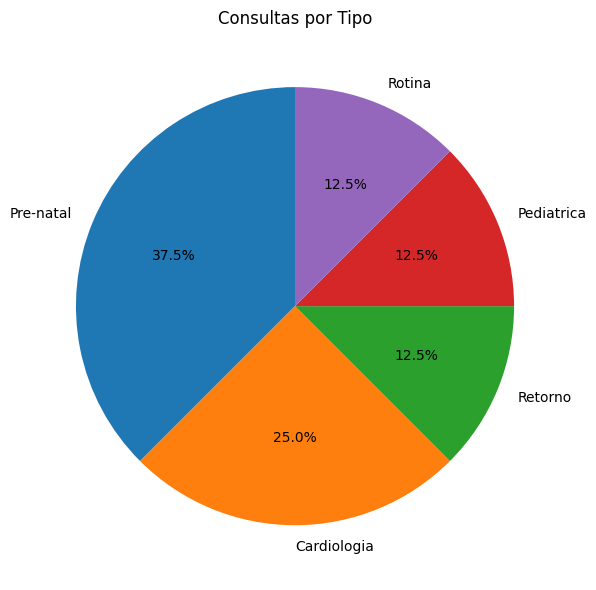

,tipo_consulta,total
0,Pre-natal,3
1,Cardiologia,2
2,Retorno,1
3,Pediatrica,1
4,Rotina,1


In [36]:
# Consultas por tipo (pizza)
grafico_consultas_por_tipo()

In [ ]:
# Consultas por mes (barras)
grafico_consultas_por_mes()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


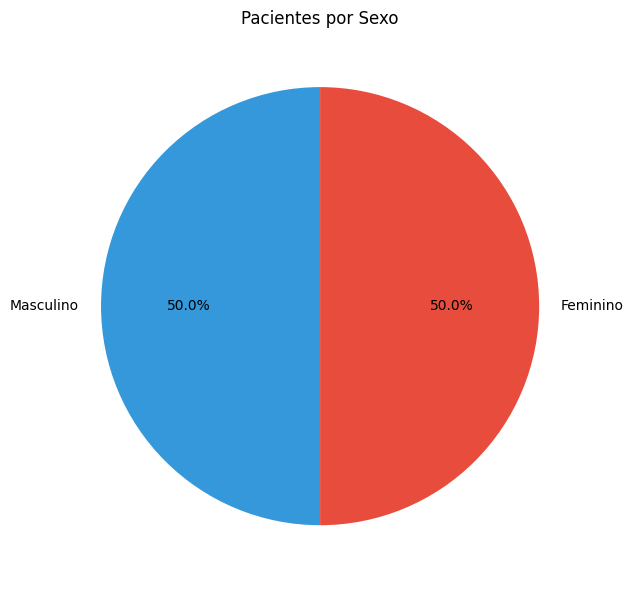

,sexo,total
0,Masculino,3
1,Feminino,3


In [37]:
# Pacientes por sexo (pizza)
grafico_pacientes_por_sexo()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:86: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


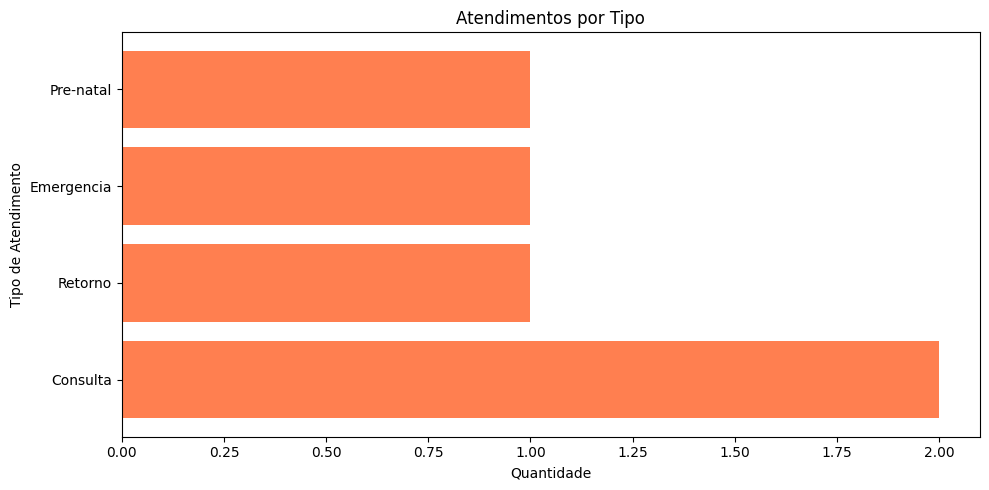

,tipo_atendimento,total
0,Consulta,2
1,Retorno,1
2,Emergencia,1
3,Pre-natal,1


In [38]:
# Atendimentos por tipo (barras horizontais)
grafico_atendimentos_por_tipo()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:110: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


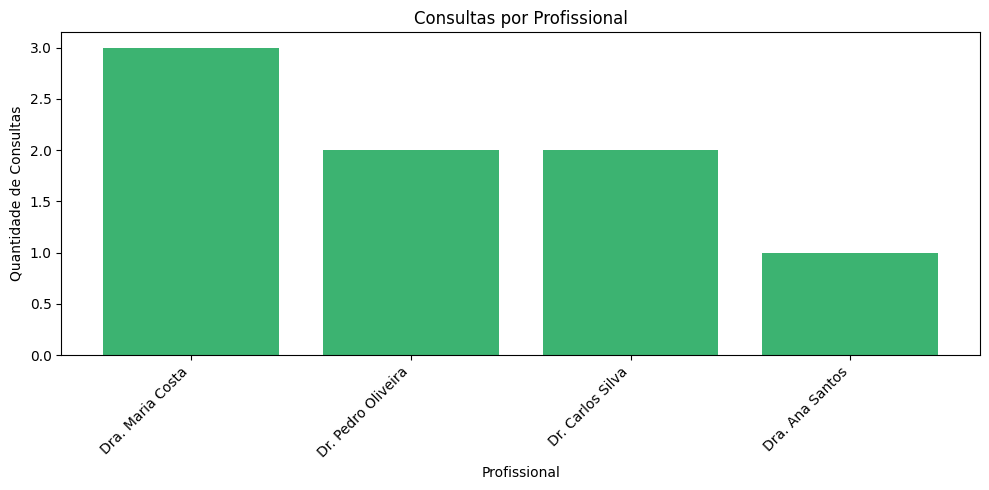

,nome,total
0,Dra. Maria Costa,3
1,Dr. Pedro Oliveira,2
2,Dr. Carlos Silva,2
3,Dra. Ana Santos,1


In [39]:
# Consultas por profissional
grafico_consultas_por_profissional()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:135: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


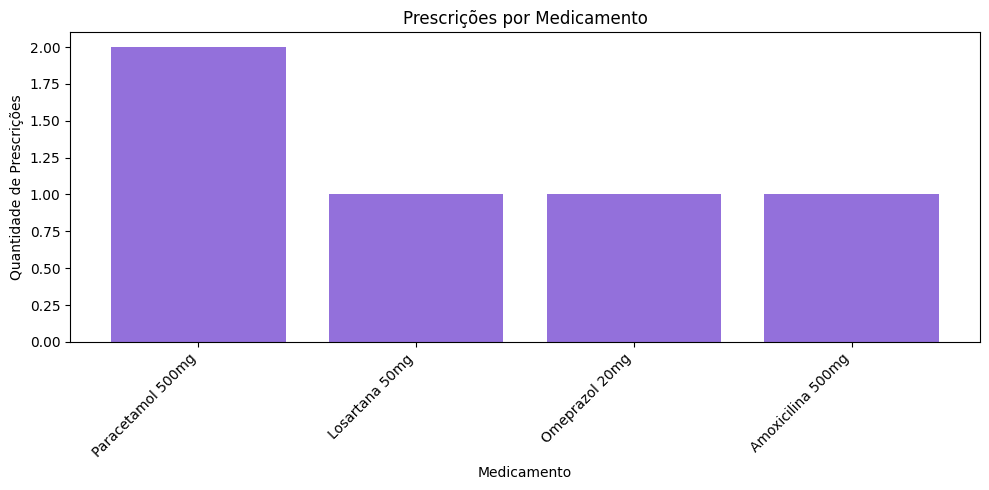

,medicamento,total
0,Paracetamol 500mg,2
1,Losartana 50mg,1
2,Omeprazol 20mg,1
3,Amoxicilina 500mg,1


In [40]:
# Prescricoes por medicamento
grafico_prescricoes_por_medicamento()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:161: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


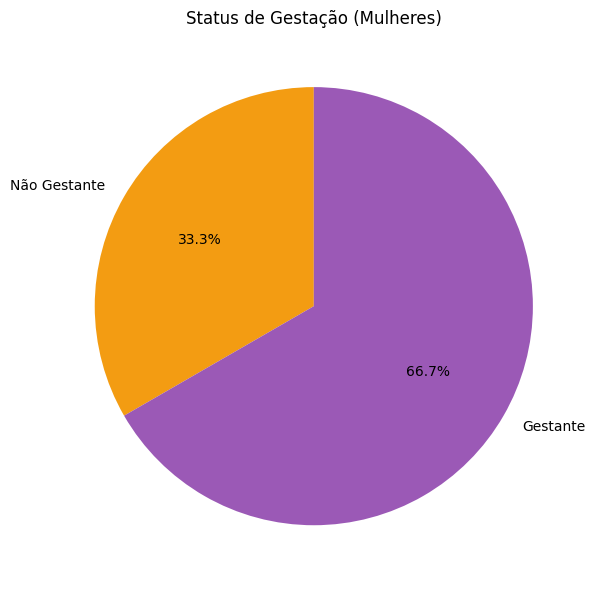

,status,total
0,Não Gestante,1
1,Gestante,2


In [41]:
# Status de gestacao (mulheres)
grafico_gestantes()

---

## Interface Grafica com Panel

**Tela interativa para o Sistema de Assistencia a Saude**

In [3]:

pn.extension()
pn.extension('tabulator')
pn.extension(notifications=True)

In [4]:

flag = ''

w_pessoa_nome = pn.widgets.TextInput(
    name="Nome",
    value='',
    placeholder='Digite o nome do paciente',
    width=250
)

w_pessoa_cpf = pn.widgets.TextInput(
    name="CPF",
    value='',
    placeholder='Digite o CPF',
    width=250
)

w_pessoa_sexo = pn.widgets.Select(
    name='Sexo',
    options=['Todos', 'M', 'F'],
    value='Todos',
    width=150
)

w_pessoa_gestante = pn.widgets.Select(
    name='Gestante',
    options=['Todos', 'Sim', 'Nao'],
    value='Todos',
    width=150
)

# --- Aba Consultas ---
w_consulta_paciente = pn.widgets.TextInput(
    name="Paciente",
    value='',
    placeholder='Nome do paciente',
    width=250
)

w_consulta_profissional = pn.widgets.TextInput(
    name="Profissional",
    value='',
    placeholder='Nome do profissional',
    width=250
)

w_consulta_tipo = pn.widgets.TextInput(
    name="Tipo de Consulta",
    value='',
    placeholder='Ex: Rotina, Retorno...',
    width=200
)

w_consulta_data_inicio = pn.widgets.DatePicker(
    name='Data Inicio',
    width=150
)

w_consulta_data_fim = pn.widgets.DatePicker(
    name='Data Fim',
    width=150
)

# --- Aba Profissionais ---
w_prof_nome = pn.widgets.TextInput(
    name="Nome",
    value='',
    placeholder='Nome do profissional',
    width=250
)

w_prof_especialidade = pn.widgets.TextInput(
    name="Especialidade",
    value='',
    placeholder='Ex: Clinico Geral',
    width=200
)

w_prof_agencia = pn.widgets.TextInput(
    name="Agencia",
    value='',
    placeholder='Nome da agencia',
    width=200
)

w_atend_paciente = pn.widgets.TextInput(
    name="Paciente",
    value='',
    placeholder='Nome do paciente',
    width=250
)

w_atend_tipo = pn.widgets.TextInput(
    name="Tipo de Atendimento",
    value='',
    placeholder='Ex: Vacinacao',
    width=200
)

w_atend_data_inicio = pn.widgets.DatePicker(
    name='Data Inicio',
    width=150
)

w_atend_data_fim = pn.widgets.DatePicker(
    name='Data Fim',
    width=150
)

w_presc_paciente = pn.widgets.TextInput(
    name="Paciente",
    value='',
    placeholder='Nome do paciente',
    width=250
)

w_presc_medicamento = pn.widgets.TextInput(
    name="Medicamento",
    value='',
    placeholder='Nome do medicamento',
    width=250
)

w_excluir_id = pn.widgets.IntInput(
    name="ID para Excluir",
    value=None,
    placeholder='Digite o ID',
    width=150
)

print("Widgets criados!")

Widgets criados!


In [5]:

btn_consultar_pessoas = pn.widgets.Button(name='Consultar Pessoas', button_type='primary', width=200)
btn_excluir_pessoa = pn.widgets.Button(name='Excluir Pessoa', button_type='danger', width=200)

btn_consultar_consultas = pn.widgets.Button(name='Consultar', button_type='primary', width=200)
btn_excluir_consulta = pn.widgets.Button(name='Excluir Consulta', button_type='danger', width=200)

btn_consultar_profissionais = pn.widgets.Button(name='Consultar Profissionais', button_type='primary', width=200)

btn_consultar_atendimentos = pn.widgets.Button(name='Consultar Atendimentos', button_type='primary', width=200)

btn_consultar_prescricoes = pn.widgets.Button(name='Consultar Prescricoes', button_type='primary', width=200)

btn_grafico_tipo_consulta = pn.widgets.Button(name='Consultas por Tipo', button_type='success', width=180)
btn_grafico_consultas_mes = pn.widgets.Button(name='Consultas por Mes', button_type='success', width=180)
btn_grafico_sexo = pn.widgets.Button(name='Pacientes por Sexo', button_type='success', width=180)
btn_grafico_atendimentos = pn.widgets.Button(name='Atendimentos por Tipo', button_type='success', width=180)
btn_grafico_profissional = pn.widgets.Button(name='Consultas por Profissional', button_type='success', width=180)
btn_grafico_prescricoes = pn.widgets.Button(name='Prescricoes por Medicamento', button_type='success', width=180)
btn_grafico_gestantes = pn.widgets.Button(name='Status Gestacao', button_type='success', width=180)

print("Botoes criados!")

Botoes criados!


In [6]:

def query_pessoas():
    """Consulta pessoas com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                p.id,
                p.nome,
                p.cpf,
                p.data_nascimento,
                p.sexo,
                p.gestante,
                p.deficiencia,
                p.telefone,
                f.codigo_familiar
            FROM Pessoa p
            JOIN Familia f ON p.familia_id = f.id
            WHERE 1=1
        """
        params = []
        
        if w_pessoa_nome.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_pessoa_nome.value}%')
        
        if w_pessoa_cpf.value:
            query += " AND p.cpf ILIKE %s"
            params.append(f'%{w_pessoa_cpf.value}%')
        
        if w_pessoa_sexo.value != 'Todos':
            query += " AND p.sexo = %s"
            params.append(w_pessoa_sexo.value)
        
        if w_pessoa_gestante.value != 'Todos':
            query += " AND p.gestante = %s"
            params.append(w_pessoa_gestante.value == 'Sim')
        
        query += " ORDER BY p.nome"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar pessoas: {str(e)}', alert_type='danger')


def query_consultas():
    """Consulta consultas medicas com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                c.id,
                p.nome AS paciente,
                pr.nome AS profissional,
                pr.especialidade,
                c.data_consulta,
                c.hora_consulta,
                c.tipo_consulta
            FROM Consulta c
            JOIN Pessoa p ON c.pessoa_id = p.id
            JOIN Profissional pr ON c.profissional_id = pr.id
            WHERE 1=1
        """
        params = []
        
        if w_consulta_paciente.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_consulta_paciente.value}%')
        
        if w_consulta_profissional.value:
            query += " AND pr.nome ILIKE %s"
            params.append(f'%{w_consulta_profissional.value}%')
        
        if w_consulta_tipo.value:
            query += " AND c.tipo_consulta ILIKE %s"
            params.append(f'%{w_consulta_tipo.value}%')
        
        if w_consulta_data_inicio.value:
            query += " AND c.data_consulta >= %s"
            params.append(w_consulta_data_inicio.value)
        
        if w_consulta_data_fim.value:
            query += " AND c.data_consulta <= %s"
            params.append(w_consulta_data_fim.value)
        
        query += " ORDER BY c.data_consulta DESC, c.hora_consulta DESC"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar consultas: {str(e)}', alert_type='danger')


def query_profissionais():
    """Consulta profissionais com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                pr.id,
                pr.nome,
                pr.cpf,
                pr.telefone,
                pr.email,
                pr.especialidade,
                a.nome AS agencia
            FROM Profissional pr
            JOIN Agencia a ON pr.agencia_id = a.id
            WHERE 1=1
        """
        params = []
        
        if w_prof_nome.value:
            query += " AND pr.nome ILIKE %s"
            params.append(f'%{w_prof_nome.value}%')
        
        if w_prof_especialidade.value:
            query += " AND pr.especialidade ILIKE %s"
            params.append(f'%{w_prof_especialidade.value}%')
        
        if w_prof_agencia.value:
            query += " AND a.nome ILIKE %s"
            params.append(f'%{w_prof_agencia.value}%')
        
        query += " ORDER BY pr.nome"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar profissionais: {str(e)}', alert_type='danger')


def query_atendimentos():
    """Consulta atendimentos com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                a.id,
                p.nome AS paciente,
                pr.nome AS profissional,
                us.nome AS unidade_saude,
                a.data_atendimento,
                a.tipo_atendimento,
                a.descricao
            FROM Atendimento a
            JOIN Pessoa p ON a.pessoa_id = p.id
            JOIN Profissional pr ON a.profissional_id = pr.id
            LEFT JOIN UnidadeSaude us ON a.unidade_saude_id = us.id
            WHERE 1=1
        """
        params = []
        
        if w_atend_paciente.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_atend_paciente.value}%')
        
        if w_atend_tipo.value:
            query += " AND a.tipo_atendimento ILIKE %s"
            params.append(f'%{w_atend_tipo.value}%')
        
        if w_atend_data_inicio.value:
            query += " AND a.data_atendimento >= %s"
            params.append(w_atend_data_inicio.value)
        
        if w_atend_data_fim.value:
            query += " AND a.data_atendimento <= %s"
            params.append(w_atend_data_fim.value)
        
        query += " ORDER BY a.data_atendimento DESC"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar atendimentos: {str(e)}', alert_type='danger')


def query_prescricoes():
    """Consulta prescricoes com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                pr.id,
                p.nome AS paciente,
                prof.nome AS profissional,
                m.nome AS medicamento,
                m.principio_ativo,
                pr.data_prescricao,
                pr.dosagem,
                pr.frequencia,
                pr.instrucoes
            FROM Prescricao pr
            JOIN Pessoa p ON pr.pessoa_id = p.id
            JOIN Profissional prof ON pr.profissional_id = prof.id
            JOIN Medicamento m ON pr.medicamento_id = m.id
            WHERE 1=1
        """
        params = []
        
        if w_presc_paciente.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_presc_paciente.value}%')
        
        if w_presc_medicamento.value:
            query += " AND m.nome ILIKE %s"
            params.append(f'%{w_presc_medicamento.value}%')
        
        query += " ORDER BY pr.data_prescricao DESC"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar prescricoes: {str(e)}', alert_type='danger')


def excluir_consulta_interface():
    """Exclui uma consulta pelo ID"""
    try:
        if w_excluir_id.value is None:
            return pn.pane.Alert('Informe o ID da consulta para excluir!', alert_type='warning')
        
        conn = conectar()
        cursor = conn.cursor()
        cursor.execute("DELETE FROM Consulta WHERE id = %s", (w_excluir_id.value,))
        rows_deleted = cursor.rowcount
        conn.commit()
        cursor.close()
        conn.close()
        
        if rows_deleted > 0:
            return pn.pane.Alert(f'Consulta ID {w_excluir_id.value} excluida com sucesso!', alert_type='success')
        else:
            return pn.pane.Alert(f'Nenhuma consulta encontrada com ID {w_excluir_id.value}', alert_type='warning')
    except Exception as e:
        return pn.pane.Alert(f'Erro ao excluir consulta: {str(e)}', alert_type='danger')


print("Funcoes de consulta da interface criadas!")

Funcoes de consulta da interface criadas!


In [7]:

import matplotlib.pyplot as plt
from io import BytesIO

def criar_grafico_tipo_consulta():
    """Grafico de pizza - Consultas por tipo"""
    try:
        conn = conectar()
        query = """
            SELECT tipo_consulta, COUNT(*) as total
            FROM Consulta
            GROUP BY tipo_consulta
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.pie(df['total'], labels=df['tipo_consulta'], autopct='%1.1f%%', startangle=90)
        ax.set_title('Consultas por Tipo')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_consultas_mes():
    """Grafico de barras - Consultas por mes"""
    try:
        conn = conectar()
        query = """
            SELECT 
                TO_CHAR(data_consulta, 'YYYY-MM') as mes,
                COUNT(*) as total
            FROM Consulta
            GROUP BY TO_CHAR(data_consulta, 'YYYY-MM')
            ORDER BY mes
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(df['mes'], df['total'], color='steelblue')
        ax.set_xlabel('Mes')
        ax.set_ylabel('Quantidade')
        ax.set_title('Consultas por Mes')
        plt.xticks(rotation=45)
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_sexo():
    """Grafico de pizza - Pacientes por sexo"""
    try:
        conn = conectar()
        query = """
            SELECT 
                CASE sexo WHEN 'M' THEN 'Masculino' ELSE 'Feminino' END as sexo,
                COUNT(*) as total
            FROM Pessoa
            GROUP BY sexo
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = ['#3498db', '#e74c3c']
        ax.pie(df['total'], labels=df['sexo'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title('Pacientes por Sexo')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_atendimentos():
    """Grafico de barras horizontais - Atendimentos por tipo"""
    try:
        conn = conectar()
        query = """
            SELECT tipo_atendimento, COUNT(*) as total
            FROM Atendimento
            GROUP BY tipo_atendimento
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.barh(df['tipo_atendimento'], df['total'], color='coral')
        ax.set_xlabel('Quantidade')
        ax.set_ylabel('Tipo de Atendimento')
        ax.set_title('Atendimentos por Tipo')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_profissional():
    """Grafico de barras - Consultas por profissional"""
    try:
        conn = conectar()
        query = """
            SELECT pr.nome, COUNT(*) as total
            FROM Consulta c
            JOIN Profissional pr ON c.profissional_id = pr.id
            GROUP BY pr.nome
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(df['nome'], df['total'], color='mediumseagreen')
        ax.set_xlabel('Profissional')
        ax.set_ylabel('Quantidade de Consultas')
        ax.set_title('Consultas por Profissional')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_prescricoes():
    """Grafico de barras - Prescricoes por medicamento"""
    try:
        conn = conectar()
        query = """
            SELECT m.nome as medicamento, COUNT(*) as total
            FROM Prescricao p
            JOIN Medicamento m ON p.medicamento_id = m.id
            GROUP BY m.nome
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(df['medicamento'], df['total'], color='mediumpurple')
        ax.set_xlabel('Medicamento')
        ax.set_ylabel('Quantidade de Prescricoes')
        ax.set_title('Prescricoes por Medicamento')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_gestantes():
    """Grafico de pizza - Gestantes vs Nao gestantes (mulheres)"""
    try:
        conn = conectar()
        query = """
            SELECT 
                CASE WHEN gestante THEN 'Gestante' ELSE 'Nao Gestante' END as status,
                COUNT(*) as total
            FROM Pessoa
            WHERE sexo = 'F'
            GROUP BY gestante
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = ['#f39c12', '#9b59b6']
        ax.pie(df['total'], labels=df['status'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title('Status de Gestacao (Mulheres)')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


print("Funcoes de graficos para interface criadas!")

Funcoes de graficos para interface criadas!


In [8]:

resultado_pessoas = pn.Column()
resultado_consultas = pn.Column()
resultado_profissionais = pn.Column()
resultado_atendimentos = pn.Column()
resultado_prescricoes = pn.Column()
resultado_graficos = pn.Column()

def callback_consultar_pessoas(event):
    resultado_pessoas.clear()
    resultado_pessoas.append(query_pessoas())

def callback_consultar_consultas(event):
    resultado_consultas.clear()
    resultado_consultas.append(query_consultas())

def callback_excluir_consulta(event):
    resultado_consultas.clear()
    resultado_consultas.append(excluir_consulta_interface())
    resultado_consultas.append(query_consultas())

def callback_consultar_profissionais(event):
    resultado_profissionais.clear()
    resultado_profissionais.append(query_profissionais())

def callback_consultar_atendimentos(event):
    resultado_atendimentos.clear()
    resultado_atendimentos.append(query_atendimentos())

def callback_consultar_prescricoes(event):
    resultado_prescricoes.clear()
    resultado_prescricoes.append(query_prescricoes())

def callback_grafico_tipo(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_tipo_consulta())

def callback_grafico_mes(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_consultas_mes())

def callback_grafico_sexo(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_sexo())

def callback_grafico_atendimentos(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_atendimentos())

def callback_grafico_profissional(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_profissional())

def callback_grafico_prescricoes(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_prescricoes())

def callback_grafico_gestantes(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_gestantes())

btn_consultar_pessoas.on_click(callback_consultar_pessoas)
btn_consultar_consultas.on_click(callback_consultar_consultas)
btn_excluir_consulta.on_click(callback_excluir_consulta)
btn_consultar_profissionais.on_click(callback_consultar_profissionais)
btn_consultar_atendimentos.on_click(callback_consultar_atendimentos)
btn_consultar_prescricoes.on_click(callback_consultar_prescricoes)

btn_grafico_tipo_consulta.on_click(callback_grafico_tipo)
btn_grafico_consultas_mes.on_click(callback_grafico_mes)
btn_grafico_sexo.on_click(callback_grafico_sexo)
btn_grafico_atendimentos.on_click(callback_grafico_atendimentos)
btn_grafico_profissional.on_click(callback_grafico_profissional)
btn_grafico_prescricoes.on_click(callback_grafico_prescricoes)
btn_grafico_gestantes.on_click(callback_grafico_gestantes)

print("Callbacks configurados!")

Callbacks configurados!


In [ ]:

aba_pessoas = pn.Column(
    pn.pane.Markdown("### Filtros de Busca"),
    pn.Row(w_pessoa_nome, w_pessoa_cpf),
    pn.Row(w_pessoa_sexo, w_pessoa_gestante),
    pn.Row(btn_consultar_pessoas),
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### Resultados"),
    resultado_pessoas,
    sizing_mode='stretch_width'
)

aba_consultas = pn.Column(
    pn.pane.Markdown("### Filtros de Busca"),
    pn.Row(w_consulta_paciente, w_consulta_profissional),
    pn.Row(w_consulta_tipo),
    pn.Row(w_consulta_data_inicio, w_consulta_data_fim),
    pn.Row(btn_consultar_consultas),
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### Resultados"),
    resultado_consultas,
    sizing_mode='stretch_width'
)

aba_profissionais = pn.Column(
    pn.pane.Markdown("### Filtros de Busca"),
    pn.Row(w_prof_nome, w_prof_especialidade),
    pn.Row(w_prof_agencia),
    pn.Row(btn_consultar_profissionais),
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### Resultados"),
    resultado_profissionais,
    sizing_mode='stretch_width'
)

aba_atendimentos = pn.Column(
    pn.pane.Markdown("### Filtros de Busca"),
    pn.Row(w_atend_paciente, w_atend_tipo),
    pn.Row(w_atend_data_inicio, w_atend_data_fim),
    pn.Row(btn_consultar_atendimentos),
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### Resultados"),
    resultado_atendimentos,
    sizing_mode='stretch_width'
)

aba_prescricoes = pn.Column(
    pn.pane.Markdown("### Filtros de Busca"),
    pn.Row(w_presc_paciente, w_presc_medicamento),
    pn.Row(btn_consultar_prescricoes),
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### Resultados"),
    resultado_prescricoes,
    sizing_mode='stretch_width'
)

aba_graficos = pn.Column(
    pn.pane.Markdown("### Selecione um Grafico"),
    pn.Row(btn_grafico_tipo_consulta, btn_grafico_consultas_mes, btn_grafico_sexo),
    pn.Row(btn_grafico_atendimentos, btn_grafico_profissional),
    pn.Row(btn_grafico_prescricoes, btn_grafico_gestantes),
    pn.pane.Markdown("---"),
    resultado_graficos,
    sizing_mode='stretch_width'
)

print("Abas criadas!")

Abas criadas!


BokehModel(combine_events=True, render_bundle={'docs_json': {'a054af65-6ef8-434c-be2c-4ff2a746456b': {'version…

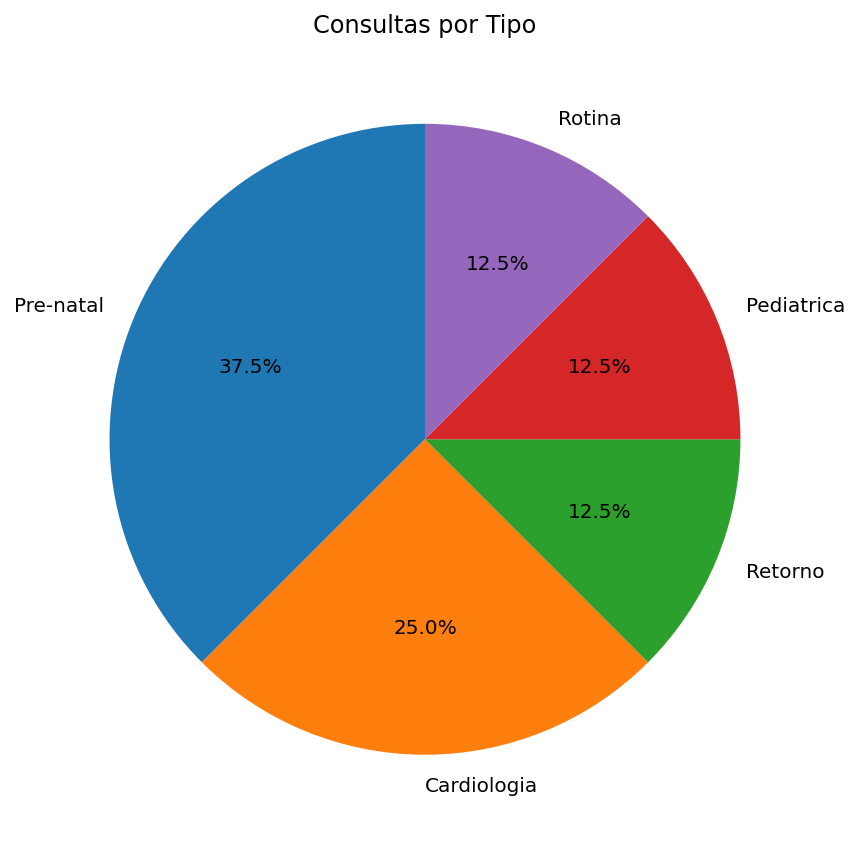

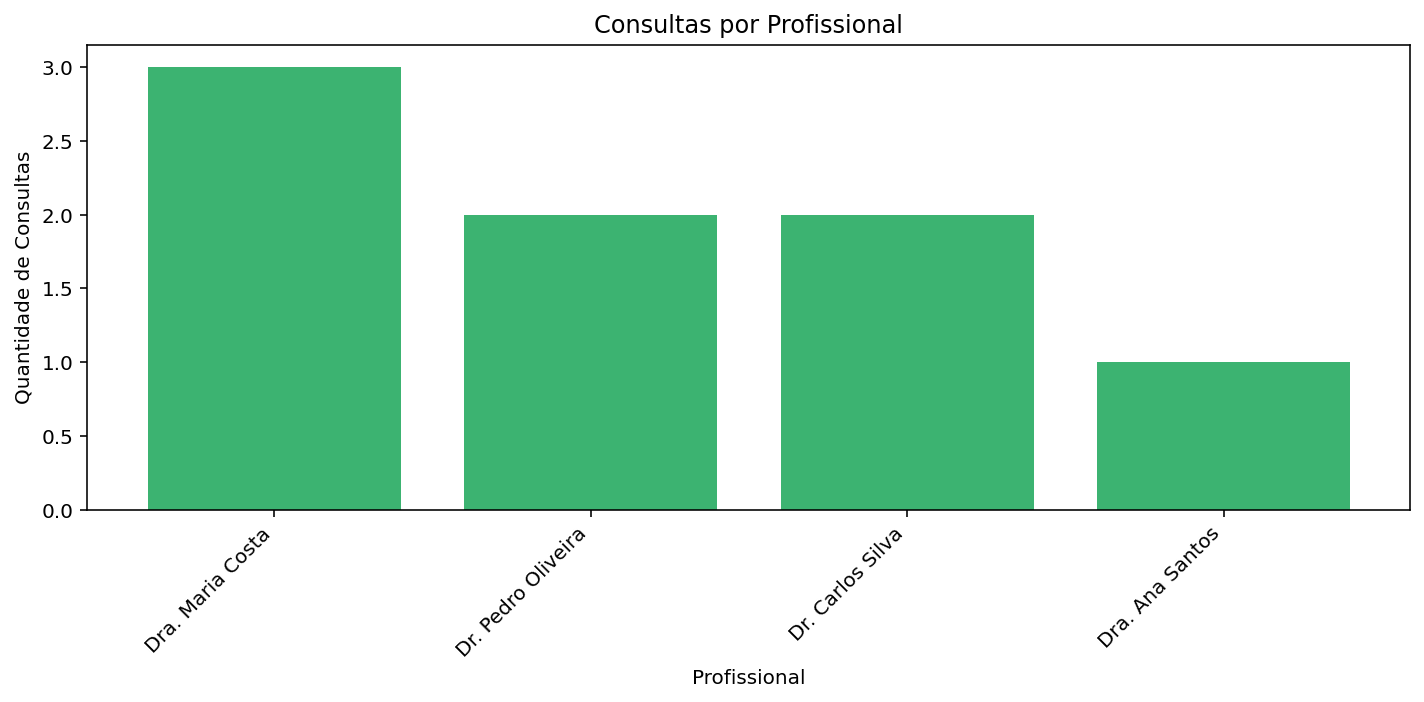

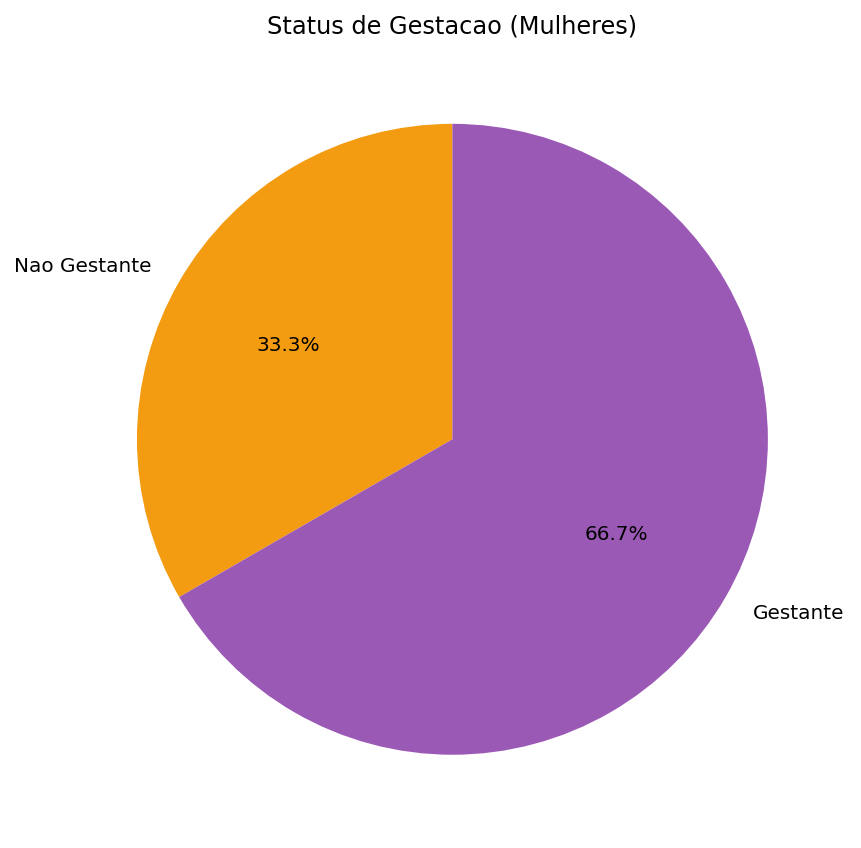

In [ ]:

interface = pn.Tabs(
    ('🧑 Pessoas', aba_pessoas),
    ('📋 Consultas', aba_consultas),
    ('👨‍⚕️ Profissionais', aba_profissionais),
    ('🏥 Atendimentos', aba_atendimentos),
    ('💊 Prescricoes', aba_prescricoes),
    ('📊 Graficos', aba_graficos),
    sizing_mode='stretch_width'
)

layout_principal = pn.Column(
    pn.pane.Markdown(
        """
        # 🏥 Sistema de Assistencia a Saude
        
        **Bem-vindo ao sistema de gerenciamento de saude!**
        
        Use as abas abaixo para navegar entre as diferentes funcionalidades:
        - **Pessoas**: Consultar pacientes cadastrados
        - **Consultas**: Buscar e gerenciar consultas medicas
        - **Profissionais**: Consultar profissionais de saude
        - **Atendimentos**: Buscar atendimentos realizados
        - **Prescricoes**: Consultar prescricoes medicas
        - **Graficos**: Visualizar estatisticas e relatorios graficos
        
        ---
        """
    ),
    interface,
    sizing_mode='stretch_width'
)


template = pn.template.BootstrapTemplate(
    title='Sistema de Assistencia a Saude',
    main=[layout_principal],
    header_background='#2c3e50',
    theme='default'
)

pn.config.raw_css = [
    """
    body {
        background-color: white !important;
    }
    .bk-root {
        background-color: white !important;
    }
    .main {
        background-color: white !important;
    }
    """
]

template.servable()